In [319]:
import pandas as pd
import numpy as np
from sklearn import tree
import graphviz
from sklearn.model_selection import cross_val_score
from utils import make_label_column_numeric
from sklearn.metrics import accuracy_score
import seaborn as sns

In [339]:
csv_path = './data/adult.data'

# Set the column names for the columns in the CSV. If the CSV's first line is a header line containing
# the column names, then set this to None.
csv_columns = [
  "Age", "Workclass", "fnlwgt", "Education", "Education-Num", "Marital-Status",
  "Occupation", "Relationship", "Race", "Sex", "Capital-Gain", "Capital-Loss",
  "Hours-per-week", "Country", "Over-50K"]

#"Age", "Hours-per-week", 
# Read the dataset from the provided CSV and print out information about it.
df = pd.read_csv(csv_path, names=csv_columns, skipinitialspace=True)

# Set the column in the dataset you wish for the model to predict
label_column = 'Over-50K'

CLASSES = ['Under-50K', 'Over-50K']

# Make the label column numeric (0 and 1), for use in our model.
# In this case, examples with a target value of '>50K' are considered to be in
# the '1' (positive) class and all other examples are considered to be in the
# '0' (negative) class.
make_label_column_numeric(df, label_column, lambda val: val == '>50K')

In [383]:
applicant_id_1 = 18932
applicant_id_2 = 18000

In [340]:
cols = df.columns
num_cols = df._get_numeric_data().columns
cat_columns = list(set(cols) - set(num_cols))

In [341]:
df = pd.get_dummies(df, columns=cat_columns)

In [342]:
df = df.sample(frac=1)# split training and testing data
d_train = df[:25000]
d_test = df[25000:]

d_train_att = d_train.drop([label_column], axis=1)
d_train_gt50 = d_train[label_column]

d_test_att = d_test.drop([label_column], axis=1)
d_test_gt50 = d_test[label_column]

d_att = df.drop([label_column], axis=1)
d_gt50 = df[label_column]

### Exploratory analysis

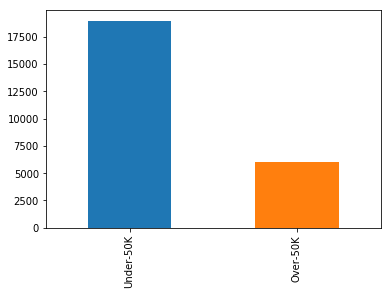

In [345]:
ax = d_train_gt50.value_counts().plot(kind='bar')
ax.set_xticklabels(CLASSES)
plt.show()

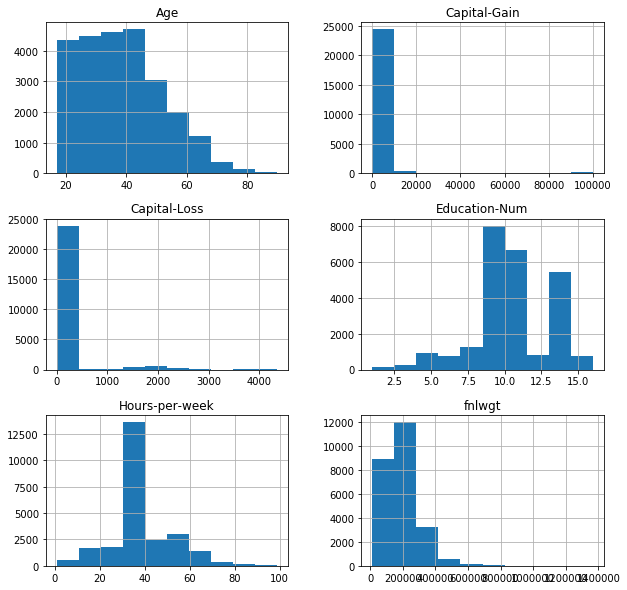

In [346]:
num_attributes = d_train_att.select_dtypes(include=['int'])
num_attributes.hist(figsize=(10,10))
plt.show()

# Decision Tree (Max depth = 3)

In [406]:
t = tree.DecisionTreeClassifier(criterion='entropy', 
                                max_depth=3, min_samples_leaf=10, min_samples_split=20)
t = t.fit(d_train_att, d_train_gt50)


In [407]:
predicted_test_decisiontree = t.predict(d_test_att)

In [408]:
accuracy_score(d_test_gt50, predicted_test_decisiontree)

0.841290834545695

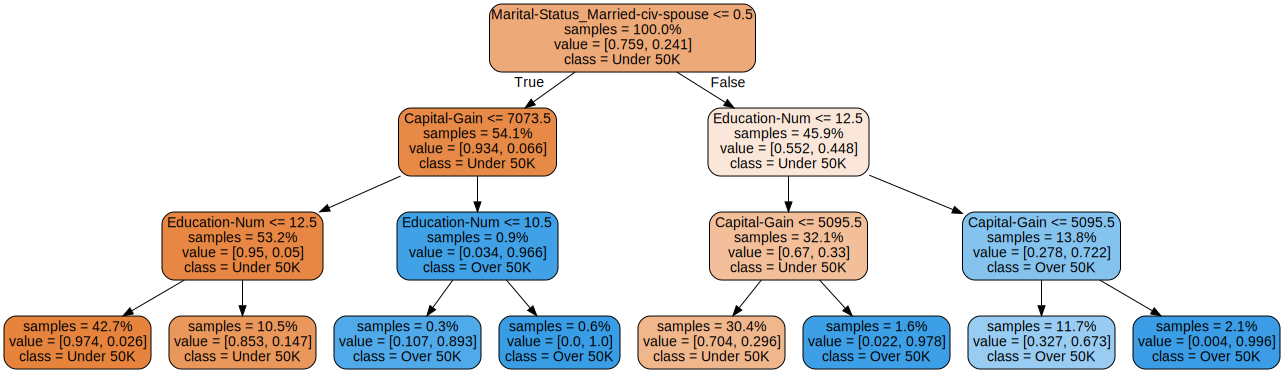

In [424]:
dot_data = tree.export_graphviz(t, out_file=None, label='all', impurity=False, proportion=True, 
                               feature_names=list(d_train_att), class_names=['Under 50K', 'Over 50K'],
                                filled=True, rounded=True)
graph = graphviz.Source(dot_data)
graph.render(filename='dt_new.dot')
graph

# Prediction for applicant 1

In [413]:
tree_predicted_applicant_1 = t.predict(d_train_att)[applicant_id_1]
tree_predicted_applicant_1

0

In [414]:
tree_predicted_applicant_2 = t.predict(d_train_att)[applicant_id_2]
tree_predicted_applicant_2

0

In [421]:
d_train_gt50.iloc[applicant_id_2]

0

### Linear 

In [348]:
from sklearn import linear_model
linear = linear_model.SGDClassifier(max_iter=1000, tol=1e-3)

In [349]:
linear.fit(d_train_att, d_train_gt50)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=1000,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=0.001,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [350]:
predicted_test_linear = linear.predict(d_test_att)

In [351]:
accuracy_score(d_test_gt50, predicted_test_linear)

0.7932813119957678

In [373]:
linear_predicted_applicant_1 = linear.predict(d_train_att)[applicant_id_1]
linear_predicted_applicant_1

0

In [412]:
linear_predicted_applicant_2 = linear.predict(d_train_att)[applicant_id_2]
linear_predicted_applicant_2

0

### User study

In [377]:
cols_userstudy = ['Age', 'Education-Num', 'Hours-per-week']

for i in cols_userstudy:
    idx = d_train_att.columns.get_loc(i)
    _coef = linear.coef_[0][idx]
    print('Feature: {}'.format(idx))
    print('    Coeff: {}'.format(_coef))
    print('    Odds: {}'.format(np.exp(_coef)))

Feature: 0
    Coeff: 6884.117354977069
    Odds: inf
Feature: 2
    Coeff: 1970.1171573944316
    Odds: inf
Feature: 5
    Coeff: 5807.035410077908
    Odds: inf


/home/amir/anaconda3/envs/dl/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys


### Extract rules

In [378]:
def tree_to_pseudo(tree, feature_names):
    left = tree.tree_.children_left
    right = tree.tree_.children_right
    threshold = tree.tree_.threshold
    features = [feature_names[i] for i in tree.tree_.feature]
    value = tree.tree_.value

    def recurse(left, right, threshold, features, node, depth=0):
        indent = "  " * depth
        if (threshold[node] != -2):
            print(indent,"if ( " + features[node] + " <= " + str(threshold[node]) + " ) {")
            if left[node] != -1:
                recurse (left, right, threshold, features, left[node], depth+1)
                print(indent,"} else {")
                if right[node] != -1:
                    recurse (left, right, threshold, features, right[node], depth+1)
                print(indent,"}")
        else:
            #print(indent,"return " + str(value[node]))
            print(indent, "return " + str(CLASSES[t.classes_[np.argmax(value[node])]]))

    recurse(left, right, threshold, features, 0)

In [379]:
tree_to_pseudo(t, list(d_train_att.columns))

 if ( Marital-Status_Married-civ-spouse <= 0.5 ) {
   if ( Capital-Gain <= 7073.5 ) {
     if ( Education-Num <= 12.5 ) {
       return Under-50K
     } else {
       return Under-50K
     }
   } else {
     if ( Education-Num <= 10.5 ) {
       return Over-50K
     } else {
       return Over-50K
     }
   }
 } else {
   if ( Education-Num <= 12.5 ) {
     if ( Capital-Gain <= 5095.5 ) {
       return Under-50K
     } else {
       return Over-50K
     }
   } else {
     if ( Capital-Gain <= 5095.5 ) {
       return Over-50K
     } else {
       return Over-50K
     }
   }
 }
